Created on thursday 7 January 2021

**Group 5 - Classification**

**V1 Innovation detection semi supervised**

@authors : Lilian Dulinge

This document is a notebook who try to define if a document talk about the "innovation" theme. We use the same processus as V0, because we define a function who seperate documents which we are sure they are talking about innovation and the documents we are sure they don't talk about about inovation. With documents classifie as innovation or not, we make labels at the others who are not classifie by function using semi-supervised methods. For training our models, we use the Bag Of Words given by G3 unlike to the V0 where we use the features. We have improved our word list, our function to define innovations, our prediction algorithms for have the best predictions. We made many graphics for see our results and improve then.

In [ ]:
import pandas as pd 
import numpy as np
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import nltk
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bow : pd.DataFrame = pd.read_json('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json')
#glove = pd.read_json('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/GloVe_v1.json')
#word2vec = pd.read_json('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/word2vec_v0.json')

In [ ]:
data : pd.DataFrame = pd.read_csv('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv')

In [ ]:
df : pd.DataFrame = pd.merge(left=bow, right=data, on='art_id')
#df = pd.merge(left=df, right=glove, left_on='art_id', right_on='art_id')
#df = pd.merge(left=df_word2vec, right=data, on='art_id')

In [ ]:
art_lemma : pd.DataFrame = pd.read_json('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')

In [ ]:
df : pd.DataFrame = pd.merge(left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [ ]:
df_lexique: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_lemma.json")

In [ ]:
column_name : list = list(bow)
column_name : list = column_name[2:]
#column_name = list(glove)
#column_name = column_name[3:]
#column_name = list(df_word2vec)
#column_name = column_name[2:]

In [ ]:
# Counts the number of words
def nb_word(text: list) -> int:
    """Documentation
      Parameters:
        text: texts of the article

      Out (if exists):
        nb_word: number of word in  the document
    """
    nb_words: list = []
    nb: int = 0
    # browse through the different texts
    for i in text:
        # removes special characters
        i.replace(',', ' ')
        i.replace('.', ' ')
        i.replace('!', ' ')
        i.replace('?', ' ')
        i.replace('/', ' ')
        # creates a list with all the words present in the text
        list_words: list = i.split()
        # counts the number of words present in the text
        nb_words.append(len(list_words))
    return nb_words

In [ ]:
# Count the number of time where the words in the list appear
def count_key_words(data: pd.DataFrame, l: list) -> list:
    """Documentation
    Parameters:
        data: List of articles
        l: List of word that we will check in the sentences

    Out (if exists):
        res: List where each value is the number of time where key word appear in the article
    """
    list_mot_unique : list =[]
    list_mot_compose : list =[]
    for elem in l :
      cpt : int = 0
      for car in elem :
        if (car == " ") :
          cpt+=1
      if cpt==0 :
        list_mot_unique.append(elem)
      else :
        list_mot_compose.append(elem)
    res: list = []
    for i in tqdm(range(len(data))):
      sentence: str = data[i]
      if sentence is None:
        res.append(0)
      else:
        sentence = sentence.lower()
        sentence = sentence.split()
        t: int = 0
        for j in sentence:
          if (j in list(list_mot_unique)):
            t = t + 1
        sentence: str = data[i]
        for elem in list_mot_compose:
          if elem in sentence:
            t = t + 1
      res.append(t)
    return res

In [ ]:
# Count the number of sentence
def sentences(data: pd.DataFrame, col: str) -> list:
    """Documentation
    Parameters:
        data: Dataframe with all the data
        columns: The columns of the dataframe that we will use

    Out (if exists):
        l: List where each value is the number of sentence in a article
    """

    l: list = []
    for i in range(len(data[col])):
        sentences: str = data[col][i]

        if not isinstance(sentences, str):
            sentences: str = str(sentences)

        if (sentences is None):
            count_sentence.append(0)
        else:
            sentences = sentences.replace("..", ".")
            sentences = sentences.replace("...", ".")
            sentences = sentences.replace("!", ".")
            sentences = sentences.replace("!!", ".")
            sentences = sentences.replace("!!!", ".")
            sentences = sentences.replace("?", ".")
            sentences = sentences.replace("??", ".")
            sentences = sentences.replace("???", ".")
            sentences = sentences.replace("?!", ".")
            sentences = sentences.replace("!?", ".")
            l.append(len(sent_tokenize(sentences)))

    return l

In [ ]:
# count the number of distinct words in each documents
def count_words_diff(df: pd.DataFrame, list_key : list) -> list :
  """Documentation
    Parameter:
        df: column who contain text of article
        list_key : list of key words
    Out:
        result: lenght of all dictionary by article, who represents the number of distinct words
  """
  result : list = []
  for j in tqdm(range(len(df))):
    liste : list = df[j].split()
    dico : dict = {}
    fait : bool = False
    for i in range(len(liste)) :
      try : 
        if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key :
          dic(liste[i]+' '+liste[i+1]+' '+liste[i+2],dico)
          fait = True
        else :
          try :
            if (liste[i]+' '+liste[i+1]) in list_key :
              dic(liste[i]+' '+liste[i+1],dico)
              fait = True
          except :
            pass
      except :
        pass
      if not fait :
        dic(liste[i],dico)
      fait = False
    result.append(len(dico))
  return result

In [ ]:
# return a dico with all the distinct word and their numbers of appearances
def comparaison_words_diff(texte: str, list_key : list) -> dict :
  """Documentation
    Parameter:
        texte: text of an article
        list_key : list of key words
    Out:
        dico: a dictionnary of all words presents in documents with numbers of their apparition
  """
  liste : list = texte.split()
  dico : dict = {}
  fait : bool = False
  for i in range(len(liste)) :
    try : 
      if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key :
        dic(liste[i]+' '+liste[i+1]+' '+liste[i+2],dico)
        fait = True
      else :
        try :
          if (liste[i]+' '+liste[i+1]) in list_key :
            dic(liste[i]+' '+liste[i+1],dico)
            fait = True
        except :
          pass
    except :
      pass
    if not fait :
      dic(liste[i],dico)
    fait = False
  return dico

In [ ]:
# count the distinct word of a list
def count_key_words_diff(liste : list) :
  """Documentation
    Parameter:
        liste: list of key words
    Out:
        dico: dictionnary with all key words in list
  """
  dico : dict = {}
  for i in range(len(liste)) :
    dic(liste[i],dico)
  return (dico)

In [ ]:
# look up a word in a dictionary
def dic(term: str,dico: dict) :
  """Documentation
    Parameter:
        term: one or set of words
        dico: dictionary
  """
  if term in dico.keys() :
    dico[term] += 1
  elif term != '' :
    dico[term] = 1

In [ ]:
# count the number of distinct key words of a list present in each text
def key_word_in_doc(df : pd.DataFrame, list_key : list) -> list:
  """Documentation
    Parameter:
        df : column of dataframe who contains all text
        list_key : list of keys word
  """
  key_word : list = []
  for i in tqdm(range(len(df))):
    sortie : dict =  comparaison_words_diff(df[i], list_key)
    liste_cle : list = []
    for cle in sortie.keys():
      liste_cle.append(cle)
    tot : int =0
    for i in liste_cle:
      if i in (list_key.tolist()):
        tot = tot + 1
    key_word.append(tot)
  return (key_word)

In [ ]:
# Use to generate weighted randomness to say if a document is innovative or not
def score_to_threshold(x: int) -> int:
    """Documentation
    Parameters:
        x: Innovation score associated with an article
    Out:
        Threshold probability used to differentiate innovative from non-innovative documents
    """
    return np.arctan(x * 100) / np.pi * 2 * 0.2 + 0.8

# Function to tell if a document is innovative
def innovation(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_nb3: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame, data_ratio3 : pd.DataFrame) -> list:
  """Documentation
    Parameters:
          data_nb1: First column of a dataframe who describe a number of key words presents in text
          data_nb2: Second column of a dataframe who describe a number of key words presents in title
          data_nb3: Third column who describe the distinct number of key word presents in text
          data_ratio1: linked column of data_nb1 who represents a ratio of key word apparition in text
          compared to the total number of words in text
          data_ratio2: linked column of data_nb2 who represents a ratio of key word apparition in title
          compared to the total number of words in title
          data_ratio3: linked column of data_nb3 who represents a ratio of distinct key word apparition in text
          compared to the total number of distinct word in text


     Parameters Out:
          list: represents score of innovation, calculate in the function innovation
      """
  res: list = []
  seuil: float = 0.15
  for i in tqdm(range(len(data_nb1))):
    valeur : float = 0.5*(data_nb1[i]*data_ratio1[i]) + 0.5*(data_nb2[i]*data_ratio2[i]) + (data_nb3[i]*data_ratio3[i])
    alea : float = np.random.random()
    if valeur > seuil:
        res.append(1)
    elif (valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0):
        res.append(0)
    elif (valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_ratio2[i] < 0.0005):
        res.append(0)
    else:
        if valeur > seuil / 2 and alea > score_to_threshold((seuil - valeur)):
            res.append(1)
        elif valeur < seuil / 2 and alea > score_to_threshold(valeur):
            res.append(0)
        else:
            res.append('?')
  return res

In [ ]:
# function to see the score given by innovation function
def score_innovation(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_nb3: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame, data_ratio3 : pd.DataFrame) -> list:
  """Documentation
    Parameters:
          data_nb1: First column of a dataframe who describe a number of key words presents in text
          data_nb2: Second column of a dataframe who describe a number of key words presents in title
          data_nb3: Third column who describe the distinct number of key word presents in text
          data_ratio1: linked column of data_nb1 who represents a ratio of key word apparition in text
          compared to the total number of words in text
          data_ratio2: linked column of data_nb2 who represents a ratio of key word apparition in title
          compared to the total number of words in title
          data_ratio3: linked column of data_nb3 who represents a ratio of distinct key word apparition in text
          compared to the total number of distinct word in text


     Parameters Out:
          list: represents score of innovation, calculate in the function innovation
      """
  res : list = []
  for i in tqdm(range(len(data_nb1))):
    valeur : float = 0.5*(data_nb1[i]*data_ratio1[i]) + 0.5*(data_nb2[i]*data_ratio2[i]) + (data_nb3[i]*data_ratio3[i])
    res.append(valeur)
  return res

In [ ]:
# function to clean our data before posting them
def preprocessing(sentence: str) -> str:
    """Documentation
    Parameters:
        data: 1 column of a dataframe especially choose because we want a column who contain only text

    Out (if exists):
        liste_return: liste of all the text of the dataframe return with preprocessing applied
    """
    stop_words: set = set(stopwords.words('french'))
    pattern: list = ['(', ')', ':', ';', ',', '&', '/',
               '"', "'", '\n', '©', 'n°', '-', 'ludivine', 'bailly','christine','verdier', 'jstories', 'dernier', 'article', 
               'jvstories', 'fabien', 'geledan', 'dgs', 'semaine', 'avril', 'deuxieme', 'septembre',
               'quels', 'pret', 'caroline', 'madame','mesdames','messieurs', 'monsieur','chere', 'martin', 'etaient',
               'comme', 'grisot', 'lancashire', 'faire','plus', 'sans', 'octobre','frédérique','jean','mathieu',
               'quand', 'rue', 'sylvain', 'decembre', 'blamer', 'situee', 'place',
               'malgré', 'levée', 'étaie', 'mène', 'poursuivis', 'malgre', 'mesures', 'ère', 'malgré',
               'journée', 'janvier', 'thématique', 'fncdg', 'autres', 'mot','art_content','jouclas',
               'tout', 'égal', 'quelle','dtype','object', 'length','name',' ob',' publiqu ','ibune',
               'créé', 'taille', 'face','après', 'dessous', 'deuxième',' nt','dé ','co ',
               'dix', 'utilisez', 'chamboule', 'postale', 'jv', 'aujourd','mar ', 
               'peut', 'cette', 'vols', 'finies',' con ',' ru','ifs',' tr','mai',
               'place', 'perdues', 'trois', 'lors','pres ','fpe',' bra',' th','date','heure',
               'art_content_clean_without_lem', 'ans', 'épidémie', 'style','dark',
               'masque', 'permis', 'toujours', 'télévision']
    if not isinstance(sentence, str):
        sentence: str = str(sentence)

    sentence: str = re.sub(r'\d', ' ', sentence)

    sentence: str = sentence.lower()

    for d in pattern:
        sentence: str = sentence.replace(d, " ")

    token_words: list = word_tokenize(sentence)
    filtre: type = [w for w in token_words if not w in stop_words]

    final_list: str = ""
    for word in filtre:
        final_list: str = final_list + word + " "
    return(final_list)

In [ ]:
# Generates a word cloud for an article
def wordcloud_art(text: str):
    """Documentation
    Parameters:
        text: the article that will be show on the word cloud
    """
    text: str = preprocessing(text)
    if len(text) > 0:
        wordcloud: str = WordCloud(relative_scaling=1.0,).generate(str(text))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        plt.close()
    else:
        print("The article have a size of 0.")

In [ ]:
# Generates a word cloud from a list of articles
def wordcloud_list_art(text: list):
    """Documentation
    Parameters:
        text: the list of articles that will be show on the word cloud
    """
    list_articles: str = ""
    for i in range(len(text)):
        list_articles: str = list_articles + text[0]
    wordcloud_art(text)

In [ ]:
# Visualization of a 2D point cloud with a PCA
def graph_2d(data: pd.DataFrame, prediction: list, dic_values: dict, transparency: float = 0.15):
    """Documentation
    Parameters:
        data: the data that will be show on the plot
        prediction: the prediction that will be used to make distinction bewteen the differents class on the plot
        dic_values: the signification of every values in the prediction
        transparency: the transparency of the points on the graph
    """
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    plt.title('Titre')
    for name_modal in dic_values:
        plt.scatter(X[prediction == dic_values[name_modal], 0], X[prediction ==
                                                                  dic_values[name_modal], 1], alpha=transparency, label=name_modal)
    plt.legend()

In [ ]:
# Visualization of a 3D point cloud with a PCA
def graph_3d(data: pd.DataFrame, prediction: pd.Series, axes=(0,1,2), opacity: int = 1):
    """Documentation
    Parameters:
        data: the data that will be show on the plot
        prediction: the prediction that will be used to make distinction bewteen the differents class on the plot
        axes: axes to plot
        opacity: the transparency of the points on the graph
    """
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction
    fig: Figure = px.scatter_3d(data_plot, x= 0, y= 1, z= 2, color='prediction', opacity=0.5)
    fig.show()

Implementation of features for predict the last labels

In [ ]:
df["nb_key_words"]: pd.DataFrame = count_key_words(df["art_lemma"], df_lexique["key_words_lemma"])
df["nb_key_words_title"]: pd.DataFrame = count_key_words(df["art_title"], df_lexique["key_words_lemma"])
df["nb_words"]: pd.DataFrame = nb_word(df['art_lemma'])
df["nb_words_title"]: pd.DataFrame = nb_word(df['art_title'])
df["nb_sentences"]: pd.DataFrame  = sentences(df, 'art_lemma')
df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
df["ratio_word_title_on_word"]: pd.DataFrame  = df["nb_words_title"] / df["nb_words"]
df['ratio_key_words']: pd.DataFrame  = df['nb_key_words']/df['nb_words']
df['ratio_key_words']: pd.DataFrame  = df['ratio_key_words'].fillna(0)
df['ratio_key_sentences']: pd.DataFrame  = df['nb_key_words']/df['nb_sentences']
df['ratio_key_sentences']: pd.DataFrame  = df['ratio_key_sentences'].fillna(0)
df['ratio_key_word_title']: pd.DataFrame  = df['nb_key_words_title'] / df['nb_words_title']
df['ratio_key_word_title']: pd.DataFrame  = df['ratio_key_word_title'].fillna(0)
df['word_key_diff']: pd.DataFrame = key_word_in_doc(df['art_lemma'], df_lexique['key_words_lemma'])
df['word_diff']: pd.DataFrame = count_words_diff(df['art_lemma'], df_lexique['key_words_lemma'])
df['ratio_key_word_diff']: pd.DataFrame  = df['word_key_diff'] / df['word_diff']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection'] : pd.DataFrame = innovation(df['nb_key_words'],df['nb_key_words_title'],df['word_key_diff'], df['ratio_key_words'],df['ratio_key_word_title'], df['ratio_key_word_diff'])
df['score_innovation'] : pd.DataFrame = score_innovation(df['nb_key_words'],df['nb_key_words_title'],df['word_key_diff'], df['ratio_key_words'],df['ratio_key_word_title'], df['ratio_key_word_diff'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



## Understand our distribution of labels

In [ ]:
df['innovation_detection'].value_counts()

?    4252
0    2095
1    1186
Name: innovation_detection, dtype: int64

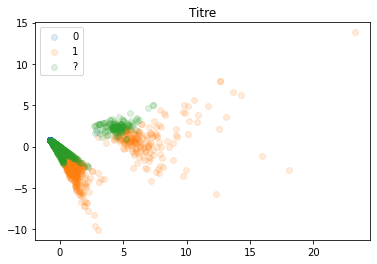

In [ ]:
graph_2d(df[['nb_key_words','nb_key_words_title','ratio_key_words','ratio_key_word_title']], df["innovation_detection"], dic_values={0:0, 1:1, "?":"?"})

In [ ]:
# function useful for create histogramme
def count_elements(seq) -> dict:
     """Tally elements from `seq`."""
     hist : dict = {}
     for i in range(len(seq)):
         hist[seq[i]] = hist.get(i, 0) + 1
     return hist

In [ ]:
dictio : dict = count_elements(df['score_innovation'])

Text(0.5, 1.0, 'score repartiton')

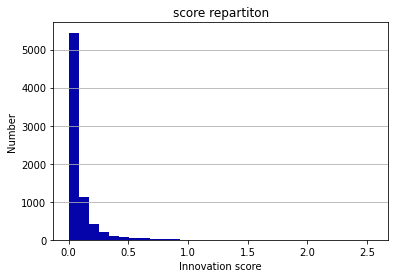

In [ ]:
n, bins, patches = plt.hist(x=df['score_innovation'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Innovation score')
plt.ylabel('Number')
plt.title('score repartiton')

Text(0.5, 1.0, 'score repartiton')

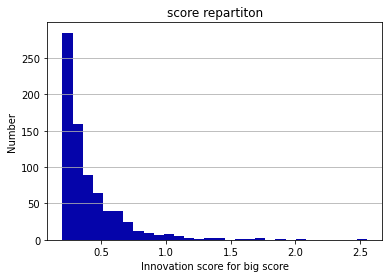

In [ ]:
df_histo : pd.DataFrame = df[df['score_innovation'] > 0.2]

n, bins, patches = plt.hist(x=df_histo['score_innovation'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Innovation score for big score')
plt.ylabel('Number')
plt.title('score repartiton')

Text(0.5, 1.0, 'score repartiton')

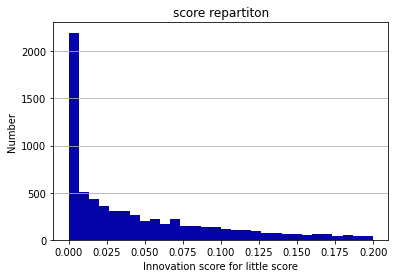

In [ ]:
df_histo : pd.DataFrame= df[df['score_innovation'] < 0.2]

n, bins, patches = plt.hist(x=df_histo['score_innovation'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Innovation score for little score')
plt.ylabel('Number')
plt.title('score repartiton')

# Prepare Data

In [ ]:
df : pd.DataFrame = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [ ]:
df['index'] : pd.DataFrame = df.index

In [ ]:
var_utile : pd.DataFrame = df[column_name]
var_utile : pd.DataFrame = pd.concat([var_utile, df['innovation_detection']], axis = 1)

In [ ]:
tout : pd.DataFrame = var_utile[var_utile['innovation_detection'] != '?']
unlabeled : pd.DataFrame = var_utile[var_utile['innovation_detection'] == '?']

In [ ]:
print(str(len(df)),str(len(tout)),str(len(unlabeled)))

7533 3281 4252


In [ ]:
trainData, testData = train_test_split(tout,
                                        test_size=0.1)

In [ ]:
X_train : pd.DataFrame = trainData.drop('innovation_detection', axis=1)
y_train : pd.DataFrame = trainData.innovation_detection

X_unlabeled : pd.DataFrame = unlabeled.drop('innovation_detection', axis=1)

X_test : pd.DataFrame = testData.drop('innovation_detection', axis=1)
y_test : pd.DataFrame = testData.innovation_detection

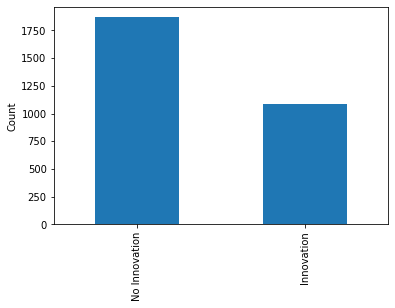

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Innovation', 'Innovation'])
plt.ylabel('Count');

In [ ]:
y_train : pd.DataFrame = pd.to_numeric(y_train)
y_test : pd.DataFrame = pd.to_numeric(y_test)

# Establishment of the learning phase

## First classifier

### Choose the best classifier for these data

Train f1 Score: 0.996299722479186
Test f1 Score: 0.9543147208121827


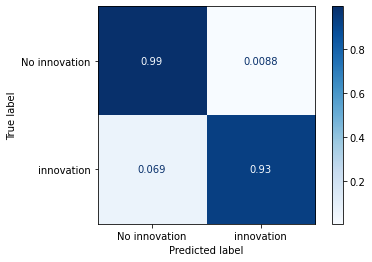

In [ ]:
# Logistic Regression

log : LogisticRegression = LogisticRegression(penalty = 'l1', solver = 'liblinear')

log.fit(X_train, y_train)
y_hat_test : np.ndarray = log.predict(X_test)
y_hat_train : np.ndarray = log.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(log, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'innovation']);

# the beautiful checkerboard

Train f1 Score: 1.0
Test f1 Score: 0.9


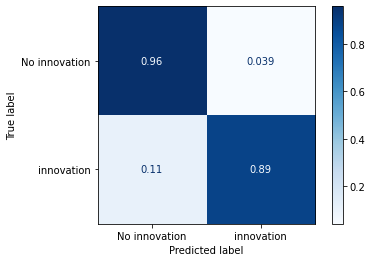

In [ ]:
# Tree Decision classifier

tree : DecisionTreeClassifier = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, y_train)
y_hat_test : np.ndarray = tree.predict(X_test)
y_hat_train : np.ndarray = tree.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(tree, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'innovation']);

Train f1 Score: 1.0
Test f1 Score: 0.9199999999999999


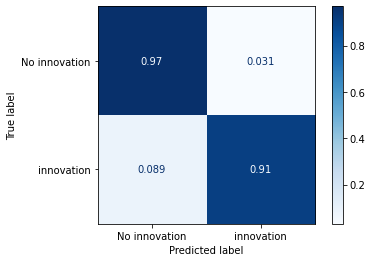

In [ ]:
# extra tree classifier

extra_tree : ExtraTreesClassifier = ExtraTreesClassifier(n_estimators=100, random_state=0)

extra_tree.fit(X_train, y_train)
y_hat_test : np.ndarray = extra_tree.predict(X_test)
y_hat_train : np.ndarray = extra_tree.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(extra_tree, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'innovation']);

# the beautiful checkerboard

Train f1 Score: 0.7862969004893963
Test f1 Score: 0.7674418604651163


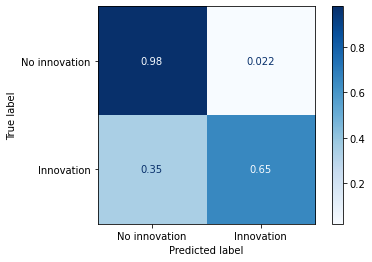

In [ ]:
# Random Forest

forest : RandomForestClassifier = RandomForestClassifier(max_depth=2, random_state=0)

forest.fit(X_train, y_train)
y_hat_test : np.ndarray = forest.predict(X_test)
y_hat_train : np.ndarray = forest.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(forest, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# the beautiful checkerboard

Train f1 Score: 0.9836981835118771
Test f1 Score: 0.9753694581280787


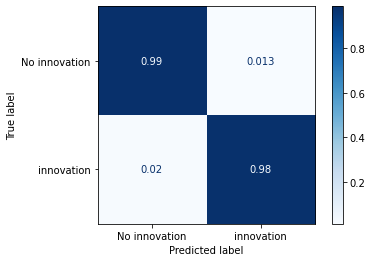

In [ ]:
# XGBoost

xgb : XGBClassifier = XGBClassifier()

xgb.fit(X_train, y_train)
y_hat_test : np.ndarray = xgb.predict(X_test)
y_hat_train : np.ndarray = xgb.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(xgb, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'innovation']);

# the beautiful checkerboard

Train f1 Score: 0.8087671232876713
Test f1 Score: 0.7484662576687116


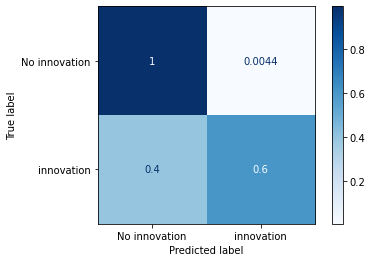

In [ ]:
# k Neighbors Classifier

knn : KNeighborsClassifier = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_hat_test : np.ndarray = knn.predict(X_test)
y_hat_train : np.ndarray = knn.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation','innovation']);

# the beautiful checkerboard

rbf :
Train f1 Score: 0.94351630867144
Test f1 Score: 0.9333333333333333

linear :
Train f1 Score: 0.94770206022187
Test f1 Score: 0.93687707641196

poly :
Train f1 Score: 0.8111011638316921
Test f1 Score: 0.7692307692307693

sigmoid :
Train f1 Score: 0.5902366863905325
Test f1 Score: 0.6178343949044586



Train f1 Score: 1.0
Test f1 Score: 0.9435897435897436


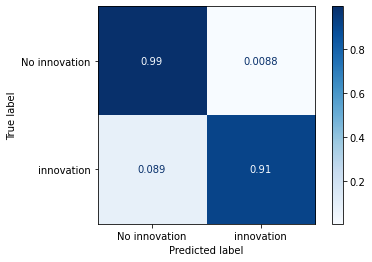

In [ ]:
# support vector machine

svc = svm.SVC(C = 4,kernel='linear', probability= True)

svc.fit(X_train, y_train)
y_hat_test : np.ndarray = svc.predict(X_test)
y_hat_train : np.ndarray = svc.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'innovation']);

# the beautiful checkerboard

Train f1 Score: 0.9935543278084714
Test f1 Score: 0.8016528925619835


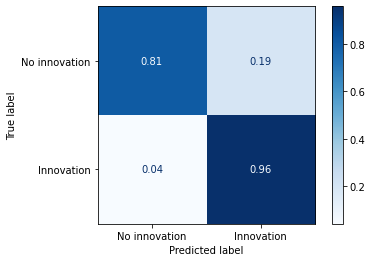

In [ ]:
# SGD classifier

clf = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))

clf.fit(X_train, y_train)
y_hat_test : np.ndarray = clf.predict(X_test)
y_hat_train : np.ndarray = clf.predict(X_train)

train_f1 : float = f1_score(y_train, y_hat_train)
test_f1 : float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# the beautiful checkerboard

In [ ]:
# Generate probabilities for each prediction

svc.predict_proba(X_test)

array([[2.55479708e-01, 7.44520292e-01],
       [9.74967042e-01, 2.50329576e-02],
       [9.50285449e-01, 4.97145509e-02],
       [2.27774575e-02, 9.77222542e-01],
       [9.11358641e-01, 8.86413594e-02],
       [1.49422570e-01, 8.50577430e-01],
       [9.94871382e-01, 5.12861752e-03],
       [2.36726622e-02, 9.76327338e-01],
       [9.37014907e-01, 6.29850925e-02],
       [9.92064302e-01, 7.93569847e-03],
       [9.94572533e-01, 5.42746692e-03],
       [3.00000090e-14, 1.00000000e+00],
       [9.52629441e-01, 4.73705595e-02],
       [4.37186349e-03, 9.95628137e-01],
       [9.43362549e-01, 5.66374510e-02],
       [9.72381809e-01, 2.76181908e-02],
       [9.99213887e-01, 7.86113147e-04],
       [9.70119989e-01, 2.98800114e-02],
       [9.15075806e-01, 8.49241940e-02],
       [9.83354876e-01, 1.66451238e-02],
       [1.45011318e-01, 8.54988682e-01],
       [9.91436076e-01, 8.56392360e-03],
       [9.33873308e-01, 6.61266924e-02],
       [6.69365983e-01, 3.30634017e-01],
       [3.000000

### After decision, train first classifier

we classify all the data for which the model is more than 99% certain of its response. We use 2 differents models to classifie with 99% safety and a last model differents of the first two with 50% of safety for classifie all the rest of data

In [ ]:
# Initiate iteration counter
iterations : int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s : list = []
test_f1s : list = []
pseudo_labels : list = []

# Assign value to initiate while loop
high_prob : list = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    svc = svm.SVC(C = 3,kernel='linear', probability= True)
    svc.fit(X_train, y_train)
    y_hat_train : np.ndarray = svc.predict(X_train)
    y_hat_test : np.ndarray = svc.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 : float = f1_score(y_train, y_hat_train)
    test_f1 : float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = svc.predict_proba(X_unlabeled)
      preds : np.ndarray = svc.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] : pd.DataFrame = preds
      df_pred_prob['prob_0'] : pd.DataFrame = prob_0
      df_pred_prob['prob_1'] : pd.DataFrame = prob_1
      df_pred_prob.index : pd.DataFrame = X_unlabeled.index
    
      # Separate predictions with > 99% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train : pd.DataFrame = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train : pd.DataFrame = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled : pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob : list = []
      print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 0.9435897435897436
Now predicting labels for unlabeled data...
995 high-probability predictions added to training data.
3257 unlabeled instances remaining.

Iteration 1
Train f1: 1.0
Test f1: 0.9435897435897436
Now predicting labels for unlabeled data...
147 high-probability predictions added to training data.
3110 unlabeled instances remaining.

Iteration 2
Train f1: 1.0
Test f1: 0.9435897435897436
Now predicting labels for unlabeled data...
51 high-probability predictions added to training data.
3059 unlabeled instances remaining.

Iteration 3
Train f1: 1.0
Test f1: 0.9435897435897436
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
3059 unlabeled instances remaining.



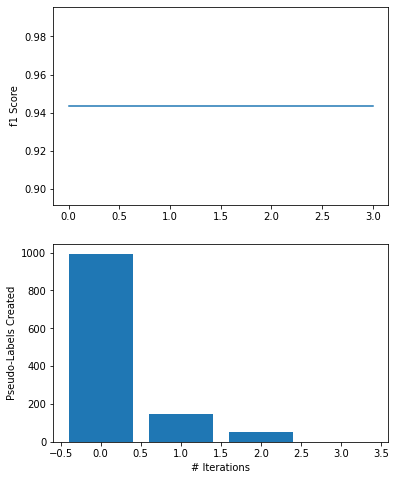

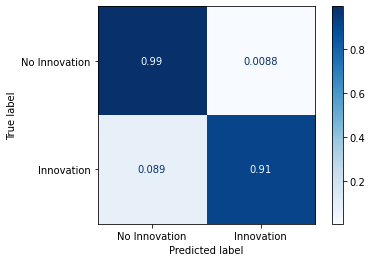

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training

plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Innovation', 'Innovation']);

## Train Second classifier for the last unlabelled data

In [ ]:
# Initiate iteration counter
iterations : int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s : list = []
test_f1s : list = []
pseudo_labels : list = []

# Assign value to initiate while loop
high_prob : list = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    log : LogisticRegression = LogisticRegression(penalty = 'l1', solver = 'liblinear')
    log.fit(X_train, y_train)
    y_hat_train : np.ndarray = log.predict(X_train)
    y_hat_test : np.ndarray = log.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 : float = f1_score(y_train, y_hat_train)
    test_f1 : float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = log.predict_proba(X_unlabeled)
      preds : np.ndarray = log.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] : pd.DataFrame = preds
      df_pred_prob['prob_0'] : pd.DataFrame = prob_0
      df_pred_prob['prob_1'] : pd.DataFrame = prob_1
      df_pred_prob.index : pd.DataFrame = X_unlabeled.index
    
      # Separate predictions with > 99% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train : pd.DataFrame = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train : pd.DataFrame = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled : pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob : list = []
      print(f'end of process.')

Iteration 0
Train f1: 0.9980682549903414
Test f1: 0.9595959595959594
Now predicting labels for unlabeled data...
1095 high-probability predictions added to training data.
1964 unlabeled instances remaining.

Iteration 1
Train f1: 0.998467824310521
Test f1: 0.9595959595959594
Now predicting labels for unlabeled data...
132 high-probability predictions added to training data.
1832 unlabeled instances remaining.

Iteration 2
Train f1: 0.9985096870342772
Test f1: 0.9494949494949495
Now predicting labels for unlabeled data...
47 high-probability predictions added to training data.
1785 unlabeled instances remaining.

Iteration 3
Train f1: 0.9985236220472442
Test f1: 0.9494949494949495
Now predicting labels for unlabeled data...
22 high-probability predictions added to training data.
1763 unlabeled instances remaining.

Iteration 4
Train f1: 0.9985279685966634
Test f1: 0.9494949494949495
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
1754 u

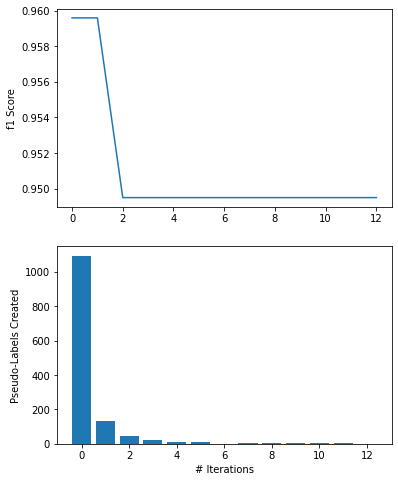

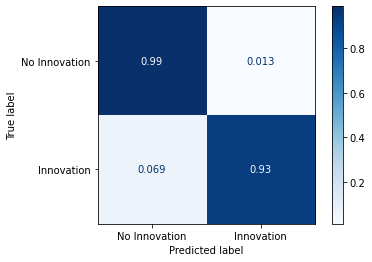

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training

plot_confusion_matrix(log, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Innovation', 'Innovation']);

## If needed, third classifier

In [ ]:
# Initiate iteration counter
iterations : int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s : list = []
test_f1s : list = []
pseudo_labels : list = []

# Assign value to initiate while loop
high_prob : list = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    xgb : XGBClassifier = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_hat_train : np.ndarray = xgb.predict(X_train)
    y_hat_test : np.ndarray = xgb.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 : float = f1_score(y_train, y_hat_train)
    test_f1 : float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = xgb.predict_proba(X_unlabeled)
      preds : np.ndarray = xgb.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] : pd.DataFrame = preds
      df_pred_prob['prob_0'] : pd.DataFrame = prob_0
      df_pred_prob['prob_1'] : pd.DataFrame = prob_1
      df_pred_prob.index : pd.DataFrame = X_unlabeled.index
    
      # Separate predictions with > 60% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.50],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.50]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train : pd.DataFrame = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train : pd.DataFrame = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled : pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob : list = []
      print(f'end of process.')

Iteration 0
Train f1: 0.9591078066914499
Test f1: 0.9484536082474228
Now predicting labels for unlabeled data...
1725 high-probability predictions added to training data.
0 unlabeled instances remaining.

Iteration 1
Train f1: 0.9390025829525134
Test f1: 0.9270833333333333
end of process.


##Recuperate data, analyse results and export results

In [ ]:
X_test['innovation_detection'] : pd.DataFrame = y_test
test_end : pd.DataFrame = X_test 

In [ ]:
X_train['innovation_detection'] : pd.DataFrame = y_train
train_end : pd.DataFrame = X_train

In [ ]:
final : pd.DataFrame = pd.concat([train_end,test_end])

In [ ]:
final['index'] : pd.DataFrame = final.index

In [ ]:
final : pd.DataFrame = final[['index','innovation_detection']]

In [ ]:
df_final : pd.DataFrame = pd.merge(left=df, right=final, left_on='index', right_on='index')

In [ ]:
data_acp : pd.DataFrame = df_final[['Nb_key_words','Nb_key_words_title','ratio_key_words','ratio_key_word_title']]
y : pd.DataFrame = df_final['innovation_detection_y']
dic_values: dict = {"Innovation": 1, "No innovation": 0}

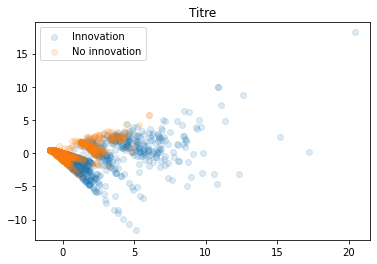

In [ ]:
graph_2d(data_acp, y, dic_values)
# graph 2D for see predictions

In [ ]:
df_final : pd.DataFrame = df_final[['art_id','innovation_detection_y']]

In [ ]:
df_final : pd.DataFrame = df_final.rename(columns = {'innovation_detection_y': 'innovation_detection_bow'})

In [ ]:
df_final.to_json("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_bow_boost_tree_V1.json")

# Result analysis

In [ ]:
data0: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

bow: pd.DataFrame = pd.read_json( "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_bow_V1.json") 
word2vec: pd.DataFrame = pd.read_json( "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_word2vec_V1.json")

df3 = pd.merge(left = data0, right = bow, on = 'art_id') 
df4 = pd.merge(left = data0, right = word2vec, on = 'art_id')

df_innovant_bow = df3[df3['innovation_detection_bow'] == 1]
df_innovant_bow = df_innovant_bow.reset_index() 

df_innovant_word2vec = df4[df4['innovation_detection_bow'] == 1]
df_innovant_word2vec = df_innovant_word2vec.reset_index()

df_non_innovant_bow = df3[df3['innovation_detection_bow'] == 0]
df_non_innovant_bow = df_non_innovant_bow.reset_index() 

df_non_innovant_word2vec = df4[df4['innovation_detection_bow'] == 0]
df_non_innovant_word2vec = df_non_innovant_word2vec.reset_index()

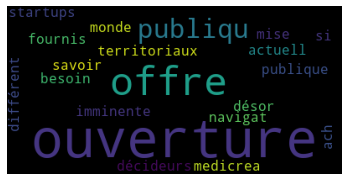

In [ ]:
wordcloud_list_art(df_innovant_bow.loc[:len(df_innovant_bow), "art_content"])
# word cloud of documents classifie as innovant with bag of words

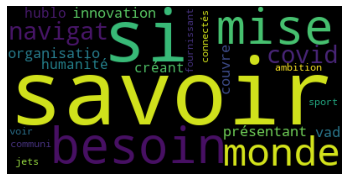

In [ ]:
wordcloud_list_art(df_innovant_word2vec.loc[:1200, "art_content"])
# word cloud of documents classifie as innovant with word2vec

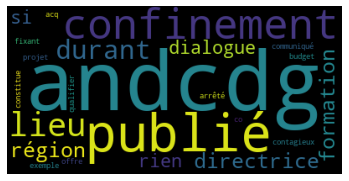

In [ ]:
wordcloud_list_art(df_non_innovant_bow.loc[:len(df_non_innovant_bow), "art_content"])
# word cloud of documents classifie as no innovant with bag of words

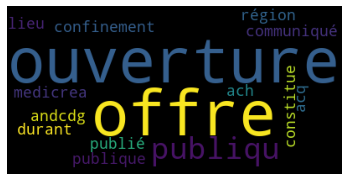

In [ ]:
wordcloud_list_art(df_non_innovant_word2vec.loc[:len(df_non_innovant_word2vec), "art_content"])
# word cloud of documents classifie as no innovant with word2vec